In [11]:
%load_ext autoreload
%autoreload 2
import copy
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch
import numpy as np
import os
from utils import config
from utils import utils
from datasets.mhad_dataloader import mhad_dataloader
from datasets.ntu_dataloader import ntu_dataloader
from utils.modules import FeatureExtractor, ActivityClassifier, Regressor
import sys
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def plot_accel(accel):
    accel = accel.cpu().detach().numpy()
    fig, ax = plt.subplots(3, 1)
    fig.subplots_adjust(hspace=0.5)
    ax[0].plot(accel[0, :], label="x", color='g')
    ax[1].plot(accel[1, :], label="y", color='g')
    ax[2].plot(accel[2, :], label="z", color='g')
    fig.legend()
    plt.show()

def plot_acceel_ontop(real_accel, pred_accel):
    real_accel = real_accel.cpu().detach().numpy()
    pred_accel = pred_accel.cpu().detach().numpy()

    fig, ax = plt.subplots(3, 1)
    fig.subplots_adjust(hspace=0.5)
    ax[0].plot(real_accel[0, :], label="x", color='g')
    ax[0].plot(pred_accel[0, :], label="pred x", color='b', linestyle='--', alpha=0.5)

    ax[1].plot(real_accel[1, :], label="y", color='g')
    ax[1].plot(pred_accel[1, :], label="pred x", color='b', linestyle='--', alpha=0.5)

    ax[2].plot(real_accel[2, :], label="z", color='g')
    ax[2].plot(pred_accel[2, :], label="pred x", color='b', linestyle='--', alpha=0.5)

    fig.legend()
    plt.show()

def plot_acceel_sidebyside(real_accel, pred_accel):
    real_accel = real_accel.cpu().detach().numpy()
    pred_accel = pred_accel.cpu().detach().numpy()

    fig, ax = plt.subplots(3, 2)
    fig.subplots_adjust(hspace=0.5)
    ax[0][0].plot(real_accel[0, :], label="x", color='g')
    ax[0][1].plot(pred_accel[0, :], label="pred x", color='b', linestyle='--')


    ax[1][0].plot(real_accel[1, :], label="y", color='g')
    ax[1][1].plot(pred_accel[1, :], label="pred x", color='b', linestyle='--')

    ax[2][0].plot(real_accel[2, :], label="z", color='g')
    ax[2][1].plot(pred_accel[2, :], label="pred x", color='b', linestyle='--')

    fig.legend()
    plt.show()

In [13]:
window = int(config.mhad_window_sec * config.mhad_accel_sampling_rate)
# pose2imu_model = RegressorNew(
#     in_ch=config.in_ch,
#     num_joints=config.num_joints,
#     window_length=window
# ).to(config.device, config.dtype)
pose2imu_model = Regressor(
    in_ch=config.in_ch,
    num_joints=config.num_joints,
    window_length=window
).to(config.device, config.dtype)
model = '05.09/12.39_0_scenario4[s=0][a=1][b=10](regressor).pth'
model_path = os.path.join(config.train_out_dir, model)
pose2imu_model.load_state_dict(torch.load(model_path, map_location=config.device))
pose2imu_model.eval() # we're not training this model

Regressor(
  (tcn1): TCNBlock(
    (conv0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (conv1): Conv2d(3, 32, kernel_size=(3, 5), stride=(1, 1), padding=same)
    (dropout1): Dropout(p=0, inplace=False)
    (conv2): Conv2d(32, 32, kernel_size=(3, 5), stride=(1, 1), padding=same)
    (dropout2): Dropout(p=0, inplace=False)
    (leakyrelu): LeakyReLU(negative_slope=0.01)
  )
  (tcn2): TCNBlock(
    (conv0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (conv1): Conv2d(32, 32, kernel_size=(3, 5), stride=(1, 1), padding=same, dilation=(2, 2))
    (dropout1): Dropout(p=0.2, inplace=False)
    (conv2): Conv2d(32, 32, kernel_size=(3, 5), stride=(1, 1), padding=same, dilation=(2, 2))
    (dropout2): Dropout(p=0.2, inplace=False)
    (leakyrelu): LeakyReLU(negative_slope=0.01)
  )
  (tcn3): TCNBlock(
    (conv0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (conv1): Conv2d(32, 32, kernel_size=(3, 5), stride=(1, 1), padding=sam

In [17]:
mhad_train_dataloader, mhad_val_dataloader, _ = mhad_dataloader()

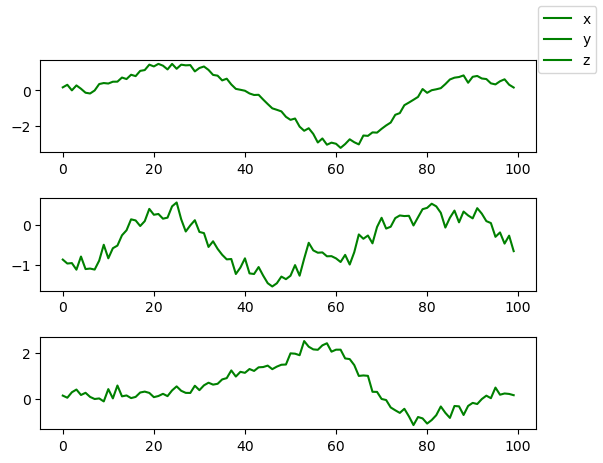

In [18]:
dataset = mhad_val_dataloader.dataset

accel, skel, _ = dataset[10]

accel = accel.to(config.device, config.dtype)
skel = skel.to(config.device, config.dtype)

pred_accel = pose2imu_model(skel.unsqueeze(0))

plot_accel(pred_accel[0, :, :])
# plot_acceel_ontop(accel[:, :], pred_accel[0, :, :])
# plot_acceel_sidebyside(accel[0, :, :], pred_accel[0, :, :])

In [7]:
ntu_train_dataloader, ntu_val_dataloader, _ = ntu_dataloader()

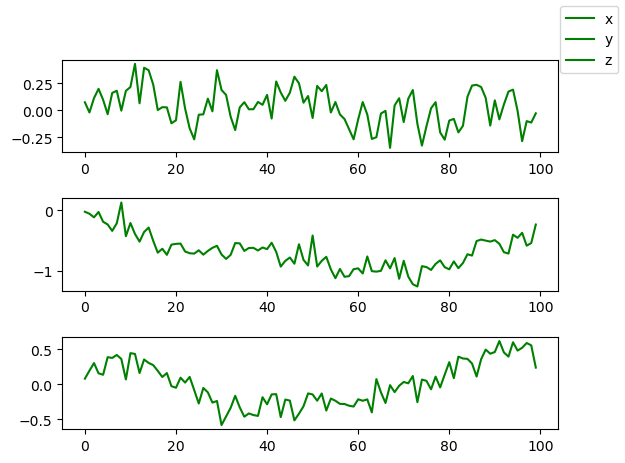

In [16]:
ntu_train_dataset = ntu_train_dataloader.dataset
skel = ntu_train_dataset[2]
skel = skel.to(config.device, config.dtype)
pred_accel = pose2imu_model(skel.unsqueeze(0))
plot_accel(pred_accel[0, :, :])

In [5]:
# >>> Scenario 1 Real <<< #
f1 = [0.9269, 0.8730, 0.9419, 0.8684]
acc = [0.9441, 0.9708, 0.9429, 0.9657]

print(f'F1: {np.mean(f1):.4f} ± {np.std(f1):.4f}')
print(f'ACC: {np.mean(acc):.4f} ± {np.std(acc):.4f}')

# >>> Scenario 1 half real half simulated <<< #
f1 = [0.8801, 0.8840, 0.8537, 0.9061, 0.9001]
acc = [0.9509, 0.9474, 0.9380, 0.9554, 0.9554]

print(f'F1: {np.mean(f1):.4f} ± {np.std(f1):.4f}')
print(f'ACC: {np.mean(acc):.4f} ± {np.std(acc):.4f}')

F1: 0.9025 ± 0.0323
ACC: 0.9559 ± 0.0125
F1: 0.8848 ± 0.0183
ACC: 0.9494 ± 0.0065


In [4]:
# >>> Scenario 2 <<< #
# [a=1][b=10]
f1 = [0.9293, 0.8942, 0.9477, 0.8812]
acc = [0.9473, 0.9747, 0.9508, 0.9663]

print(f'F1: {np.mean(f1):.4f} ± {np.std(f1):.4f}')
print(f'ACC: {np.mean(acc):.4f} ± {np.std(acc):.4f}')

# [a=1][b=0]
f1 = [0.9195, 0.9159, 0.9258, 0.9174]
acc = [0.9621, 0.9591, 0.9621, 0.9638]

print(f'F1: {np.mean(f1):.4f} ± {np.std(f1):.4f}')
print(f'ACC: {np.mean(acc):.4f} ± {np.std(acc):.4f}')

F1: 0.9131 ± 0.0266
ACC: 0.9598 ± 0.0112
F1: 0.9196 ± 0.0038
ACC: 0.9618 ± 0.0017


In [7]:
# >>> Scenario 3 <<< #
# [a=1][b=1][g=1]
f1 = [0.6623, 0.7461, 0.6024, 0.6631]
acc = [0.8885, 0.8642, 0.8283, 0.8933]

print(f'F1: {np.mean(f1):.4f} ± {np.std(f1):.4f}')
print(f'ACC: {np.mean(acc):.4f} ± {np.std(acc):.4f}')

F1: 0.6685 ± 0.0511
ACC: 0.8686 ± 0.0257


In [3]:
# >>> regression comparison <<< #
test_loss = [0.4767, 0.4963, 0.4897, 0.5077, 0.4746]

print(f'test loss: {np.mean(test_loss):.4f} ± {np.std(test_loss):.4f}')

test_loss = [0.4580, 0.4698, 0.4581]

print(f'test loss: {np.mean(test_loss):.4f} ± {np.std(test_loss):.4f}')


test loss: 0.4890 ± 0.0123
test loss: 0.4620 ± 0.0055
